In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# lesson3 Image segmentation

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## 数据集
1. [SegNet Tutorial](http://mi.eng.cam.ac.uk/projects/segnet/tutorial.html)
2. [alexgkendall/SegNet-Tutorial: Files for a tutorial to train SegNet for road scenes using the CamVid dataset](https://github.com/alexgkendall/SegNet-Tutorial)

In [3]:
# 下载数据集
# !git clone git@github.com:alexgkendall/SegNet-Tutorial.git

也可以使用 fastai 自己的数据

- **对单个图片的每个像素进行分类就是分割**

移动 CamVid 到datasets文件夹

In [4]:
# 设置数据集的路径
# root = Config.data_path()/'CamVid'
root = untar_data(URLs.CAMVID)
root

PosixPath('/home/lyc/.fastai/data/camvid')

In [5]:
# 查看路径下的文件和文件夹
root.ls()

[PosixPath('/home/lyc/.fastai/data/camvid/images'),
 PosixPath('/home/lyc/.fastai/data/camvid/labels'),
 PosixPath('/home/lyc/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/lyc/.fastai/data/camvid/valid.txt')]

## 数据处理

In [6]:
root_lbl = root/'labels'
root_img = root/'images'

In [7]:
fnames = get_image_files(root_img)
fnames[:3]

[PosixPath('/home/lyc/.fastai/data/camvid/images/0016E5_01530.png'),
 PosixPath('/home/lyc/.fastai/data/camvid/images/Seq05VD_f01620.png'),
 PosixPath('/home/lyc/.fastai/data/camvid/images/0016E5_08015.png')]

In [8]:
doc(get_image_files)

get_image_files [source] [test] get_image_files ( c : PathOrStr , check_ext : bool = True , recurse = False ) → FilePathList 
 
 × No tests found for get_image_files . To contribute a test please refer to this guide and this discussion . Return list of files in c that are images. check_ext will filter to image_extensions . 
 Show in docs

- 随机查看图片

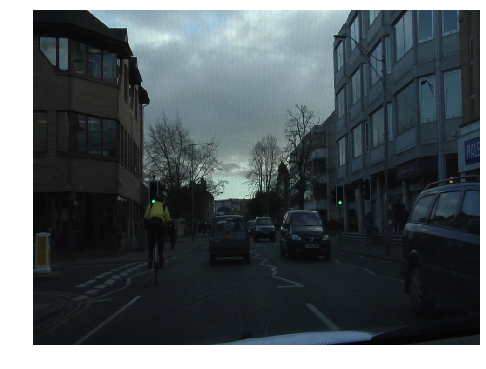

In [9]:
img_f = fnames[50]
img = open_image(img_f)
img.show(figsize=(8, 8))

- 获取对应标注的文件名

In [10]:
img_f
img_f.stem  # 文件名

PosixPath('/home/lyc/.fastai/data/camvid/images/0001TP_008490.png')

'0001TP_008490'

In [11]:
root_lbl/f'{img_f.stem}_P{img_f.suffix}'

PosixPath('/home/lyc/.fastai/data/camvid/labels/0001TP_008490_P.png')

- 获取对应的 mask 的文件名

In [12]:
get_y_fn = lambda x: root_lbl/f'{x.stem}_P{x.suffix}'

- 查看对应的 mask

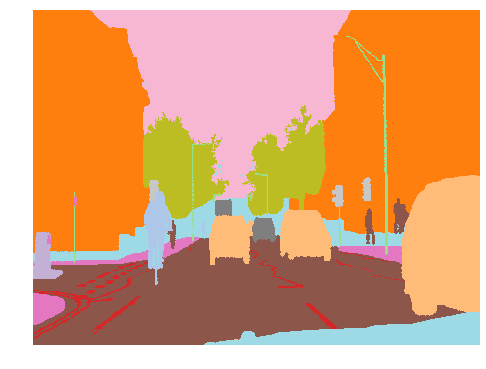

In [13]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(8,8), alpha=1)  # alpha 透明度

- mask 的相关信息

In [14]:
mask.shape
src_size = np.array(mask.shape[1:])
src_size
mask.data

torch.Size([1, 720, 960])

array([720, 960])

tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         ...,
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30]]])

In [15]:
doc(open_mask)

open_mask [source] [test] open_mask ( fn : PathOrStr , div = False , convert_mode = 'L' , after_open : Callable = None ) → ImageSegment 
 
 × No tests found for open_mask . To contribute a test please refer to this guide and this discussion . Return ImageSegment object create from mask in file fn . If div , divides pixel values by 255. 
 Show in docs

- 查看对应的标签名

In [16]:
codes = np.loadtxt(root/'codes.txt', dtype=str)
codes
# 有一个特殊的 void 表示不确定

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## 创建数据束 

In [17]:
size = src_size//2  # 图片转换大小

- 根据显存大小设置 batchsize 这个还是非常有用的

In [18]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8116:
    bs=8
else:
    bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7389MB of GPU RAM free


- 数据束创建流程
- 分割任务 SegmentationItemList

In [19]:
src = (SegmentationItemList.from_folder(root_img)
       .split_by_fname_file('../valid.txt')  # 当前文件路径即 root_img
       .label_from_func(get_y_fn, classes=codes))

- **分割任务中，对原始图像进行翻转的同时，也应当对对应的 mask 进行翻转，设置`tfm_y=True`**
- 因为需要对每个像素进行分类，所以自然而然会占用很大的空间，所以这里的batchsize应当小一些

In [20]:
doc(get_transforms)

get_transforms [source] [test] get_transforms ( do_flip : bool = True , flip_vert : bool = False , max_rotate : float = 10.0 , max_zoom : float = 1.1 , max_lighting : float = 0.2 , max_warp : float = 0.2 , p_affine : float = 0.75 , p_lighting : float = 0.75 , xtra_tfms : Optional [ Collection [ Transform ]]= None ) → Collection [ Transform ] 
 
 × Tests found for get_transforms : pytest -sv tests/test_vision_data.py::test_image_to_image_different_tfms [source] pytest -sv tests/test_vision_data.py::test_image_to_image_different_y_size [source] To run tests please refer to this guide . Utility func to easily create a list of flip, rotate, zoom , warp, lighting transforms. 
 Show in docs

In [21]:
tfms = get_transforms()

In [22]:
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [23]:
data

ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/lyc/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/lyc/.fastai/data/camvid/images;

Test: None

- 查看 batch 数据也是检查 Databunch 是否创建成功

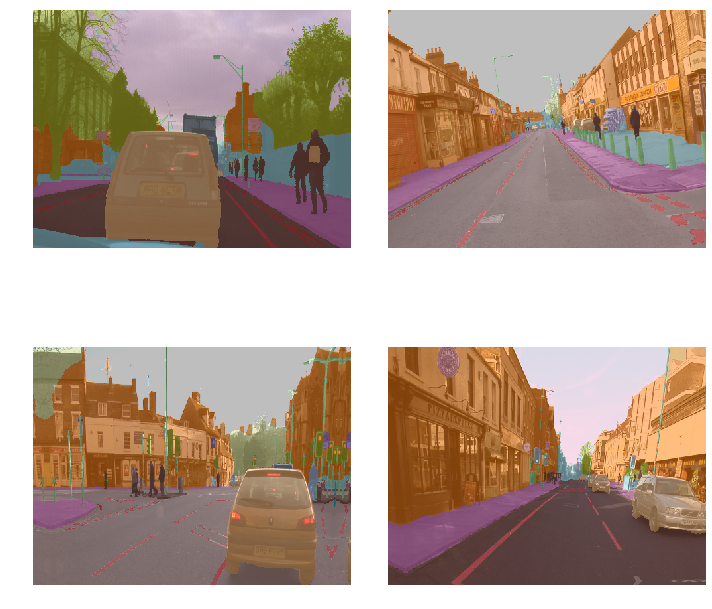

In [24]:
data.show_batch(2, figsize=(10,10))  # 训练集

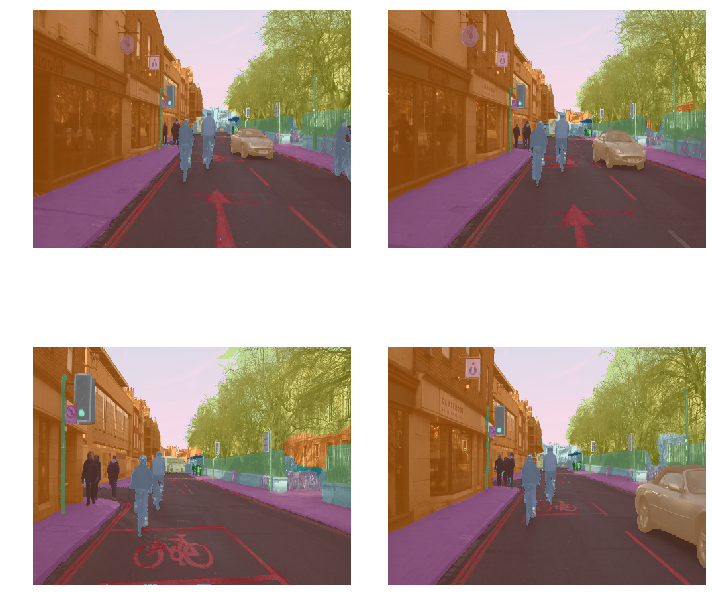

In [25]:
data.show_batch(2, figsize=(10,10), ds_type=DatasetType.Valid)  # 验证集

## 构建模型

In [26]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']  # void 不考虑
void_code

30

- 定义 metrics

In [27]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code  # 去掉 void
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

- 设置权重衰减与架构

In [28]:
wd=1e-2  # 权重衰减
arch = models.resnet34

In [29]:
learn = unet_learner(data, arch, metrics=acc_camvid, wd=wd).to_fp16()  # 使用fp16精度

- 学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


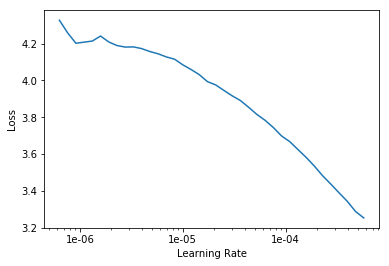

In [30]:
lr_find(learn)
learn.recorder.plot()

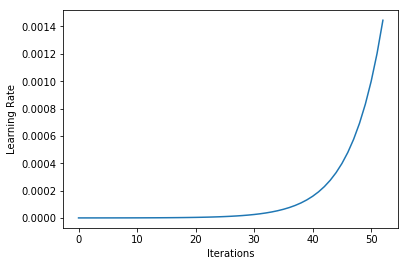

In [31]:
learn.recorder.plot_lr()

In [32]:
lr1 = 3e-4

- stage 1 训练

In [33]:
learn.fit_one_cycle(10, slice(lr1), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.512324,1.115420,0.755219,01:05
1,0.929626,0.804473,0.818650,01:05
2,0.725152,0.618935,0.840718,01:04
3,0.635814,0.561740,0.854147,01:04
4,0.617310,0.497535,0.872019,01:03
5,0.561448,0.498716,0.857903,01:04
6,0.518813,0.410810,0.884953,01:03
7,0.498793,0.379050,0.887504,01:03
8,0.454523,0.395168,0.890030,01:03
9,0.373177,0.317239,0.909865,01:04


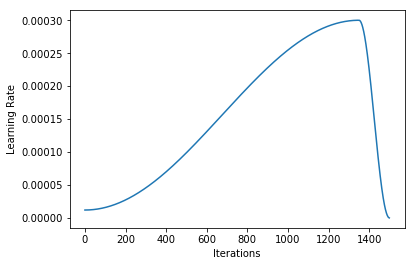

In [34]:
learn.recorder.plot_lr()

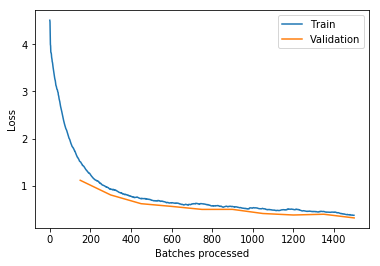

In [36]:
learn.recorder.plot_losses()

In [37]:
learn.save('stage-1-resnet34')

- 重载训练模型并查看分割结果

In [41]:
learn.load('stage-1-resnet34');

In [45]:
preds, _ = learn.get_preds()

In [53]:
preds.shape
preds[0].argmax(dim=0)

torch.Size([101, 32, 360, 480])

tensor([[ 4,  4,  4,  ..., 26, 26, 26],
        [ 4,  4,  4,  ..., 26, 26, 26],
        [ 4,  4,  4,  ..., 26, 26, 26],
        ...,
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17]])

In [58]:
data.valid_ds.items.shape

(101,)

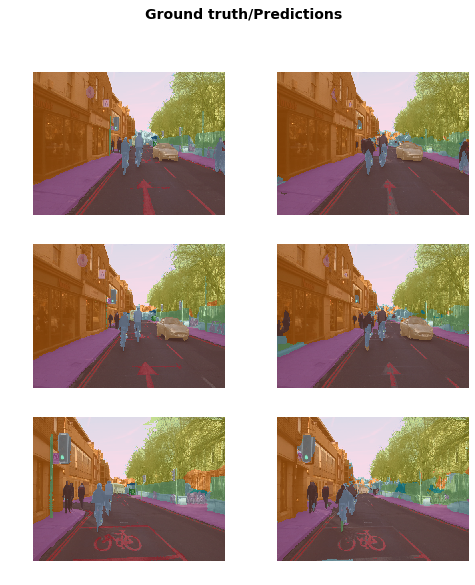

In [59]:
learn.show_results(rows=3, figsize=(8,9))

- stage 2 训练

In [60]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


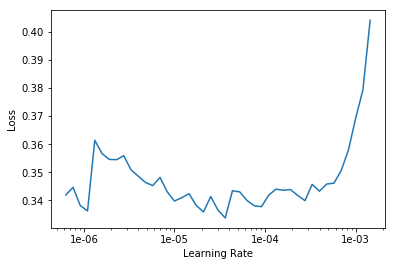

In [61]:
lr_find(learn)
learn.recorder.plot()

In [64]:
lr2=1e-4  # 这里和第一阶段的学习率差不多，注意设置slice(lr2/400, lr2)

In [65]:
lrs = slice(lr2/400, lr2)

In [68]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.269760,0.300253,0.910856,01:09
1,0.265170,0.293521,0.913397,01:08
2,0.266171,0.299362,0.912121,01:08
3,0.267367,0.300826,0.913218,01:08
4,0.267686,0.301210,0.914101,01:08
5,0.268261,0.272466,0.922364,01:08
6,0.265381,0.284470,0.917611,01:08
7,0.259283,0.329831,0.904167,01:08
8,0.250170,0.268870,0.921661,01:08
9,0.229602,0.260751,0.924449,01:08


In [69]:
learn.save('stage-2-resnet34')

## 使用更大的图片大小，并减小batchsize

In [70]:
doc(learn.destroy)

destroy [source] [test] destroy () 
 
 × Tests found for destroy : pytest -sv tests/test_basic_train.py::test_destroy [source] pytest -sv tests/test_basic_train.py::test_memory [source] To run tests please refer to this guide . Free the Learner internals, leaving just an empty shell that consumes no memory 
 Show in docs

In [71]:
learn.destroy() # uncomment once GPU is out

this Learner object self-destroyed - it still exists, but no longer usable


In [72]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
# 根据显存大小进行设置 1070TI 8116MiB
if free > 8116:
    bs=3
else:
    bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this object has been destroyed
using bs=1, have 3841MB of GPU RAM free


In [73]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [75]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd).to_fp16()

In [77]:
learn.load('stage-2-resnet34');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


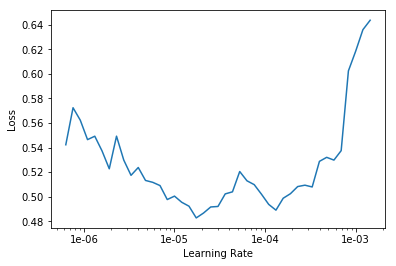

In [80]:
lr_find(learn)
learn.recorder.plot()

In [81]:
lr3 = 3e-5

In [82]:
learn.fit_one_cycle(10, slice(lr3), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.406460,0.330372,0.906941,04:21
1,0.380691,0.304985,0.914870,04:19
2,0.393220,0.310518,0.912239,04:18
3,0.324199,0.302828,0.915630,04:22
4,0.307171,0.297197,0.915479,04:26
5,0.313809,0.276102,0.923529,04:27
6,0.324710,0.284762,0.917851,04:18
7,0.288876,0.281740,0.922245,04:17
8,0.261224,0.297412,0.918275,04:24
9,0.245258,0.272802,0.925032,04:21


- 查看损失情况

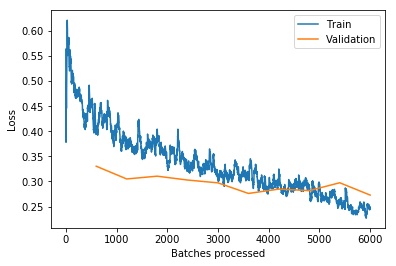

In [83]:
learn.recorder.plot_losses()

In [84]:
learn.save('stage-1-big-resnet34')

In [87]:
learn.load('stage-1-big-resnet34');

In [88]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


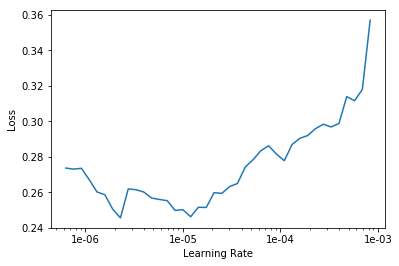

In [90]:
lr_find(learn)
learn.recorder.plot()

In [91]:
lr4 = 3e-6

In [92]:
lrs = slice(lr4/100, lr4)

In [94]:
learn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.222811,0.264694,0.925471,04:39
1,0.241975,0.273373,0.922575,04:48
2,0.230504,0.268468,0.924331,04:43
3,0.239102,0.266441,0.925164,04:48
4,0.227003,0.264406,0.926443,04:39


In [95]:
learn.save('stage-2-big-resnet34')

In [99]:
learn.load('stage-2-big-resnet34');

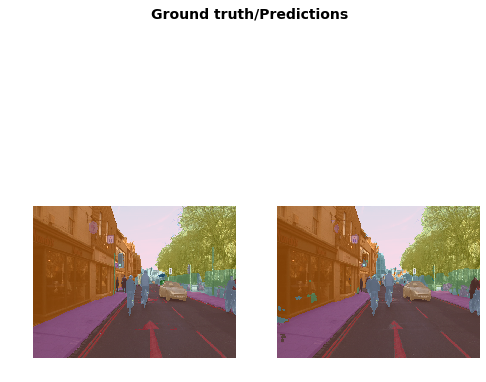

In [102]:
learn.show_results(rows=1, figsize=(8,8))

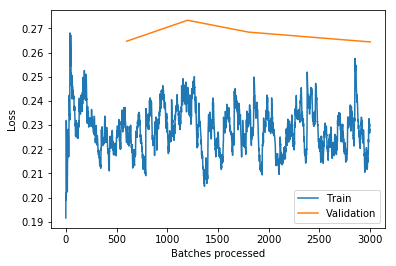

In [103]:
learn.recorder.plot_losses()

## 其他

1. 我们应当逐步增加图片的大小，在这个过程中，我们不改变已经训练好的模型，而是更改数据
2.  "progressive resizing".64 以下的数字往往不会有太大的效果，但是它很好用
3. 分类正确的像素个数/所有的像素个数=准确度
4. 存在一些像素的标签是 void 在计算准确度的时候要排除这些像素
5. fit-one-cycle(lr) 传进去的是最大的 lr
6. 一开始我们使用128的图像，但是我们的任务是分割每个像素（256），所以并没有解决问题，那么第二步要做的就是增大图像到 256
7. learn.show_results() 可以查看模型的结果
8. learner.create_unet 使用unet作为结构
9. Mixed precision training 这也是一种有效的训练方式，它可以避免模型超出内存，即可以使用半精度浮点数在模型中执行大多数计算，而不是使用单精度浮点数 fp16 而不是 fp32,而且可以加速训练（保证驱动是最新的）